# GZ3D VAC usage

How to access and use GZ3D masks.  We will start by importing mavin and some matplotlib functions

In [ ]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Increase matplotlib font size, tick size, and line thickness.

In [2]:
style = {
    'lines.linewidth': 1.5,
    'font.size': 16.0,
    'axes.linewidth': 1.5,
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'legend.fancybox': True,
    'legend.fontsize': 'small',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',
    'figure.titlesize': 'large',
}

plt.style.use(style)

## Accessing the VAC

The GZ3D data can be accessed either through the `marvin.tools.Cube` object or the `marvin.tools.Maps` object using the `.vacs.gz3d` attribute.  This attribute will return a special `GZ3DTarget` class instance that will aid in processing and using the GZ3D VAC fits files.  Calling `print` on this instance will show summary information about the GZ3D classifications.

In [3]:
manga_id = '1-604761'

cube = marvin.tools.Cube(manga_id)
data = cube.vacs.gz3d
print(data)

Subject info:
    subject id: 14742283
    manga id: 1-604761
    ra: 113.47227478027344
    dec: 37.02590560913086
    ifu size: 127
Classification counts:
    15 center/star, 15 non_blank
    15 spiral, 14 non_blank
    15 bar, 15 non_blank
Cluster counts:
    1 center(s)
    3 star(s)


## Plotting the image and masks

Each GZ3D fits file has the original image shown to the volunteers. Note the hexagon is slightly smaller than the true IFU size due to a bug in the code that make the cutout images (magenta), the correct IFU will be over layed (grey) by default when displaying the image.

Note: the source of this bug was not accounting for the space between IFU fibers when making the image for GZ3D (it assumed each fiber was 2 arcsec on the sky when in reality they are 2.5 arcsec on the sky).

To plot the original image you can use the `plot_image` method and to plot the various masks you can use the `plot_masks` method.  Below are some examples using these methods that shows how to pass in existing `axis` objects for embedding these in subplots.  Note: `plot_masks` uses matplotlib's `GridSpec` internally so it is easier to use this syntax when embedding in larger plots, but normal `axis` objects can be passed in on `subplot_spec` and it will work.

When passing in a your own `axis` object make sure the `projection` is set to the correct WCS for the image (see example below).

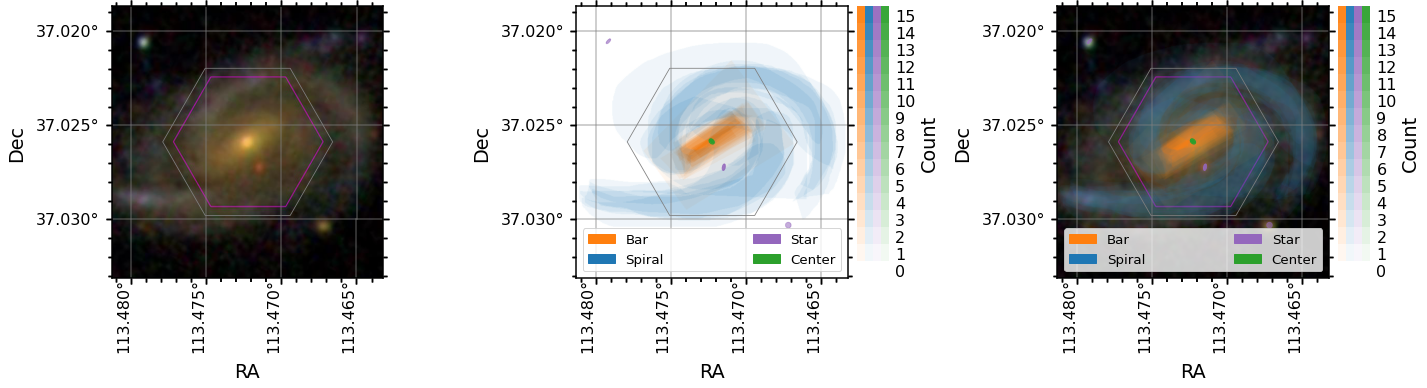

In [6]:
plt.figure(figsize=(23, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.5)

ax0 = plt.subplot(gs[0], projection=data.wcs)
data.plot_image(color_grid='grey', ax=ax0)

data.plot_masks(color_grid='grey', subplot_spec=gs[1]);

data.plot_masks(show_image=True, color_grid='grey', subplot_spec=gs[2]);

## Image vs Spaxel masks

The GZ3D feature masks are created in the coordinates of the image shown to the volunteers, but to be useful for MaNGA maps they are projected into spaxel space.  The image masks are found on the attributes `bar_mask`, `spiral_mask`, `star_mask`, and `center_mask` while the spaxel masks are found on `bar_mask_spaxel`, `spiral_mask_spaxel`, `star_mask_spaxel`, and `center_mask_spaxel`.  Below are some plots showing how this process is done.

The spaxel masks are all the same size and orientation as the `manga.tools.maps.Maps` arrays and can be used directly as masks for those arrays.

Note: The WCS for MaNGA maps (and the spaxel masks) has the y-axis flipped compared to the image (and original mask) WCS.  In the plot below the `ylim` of the axis is inverted to keep the orientation the same.  The Dec values are correct, the origin is just flipped.

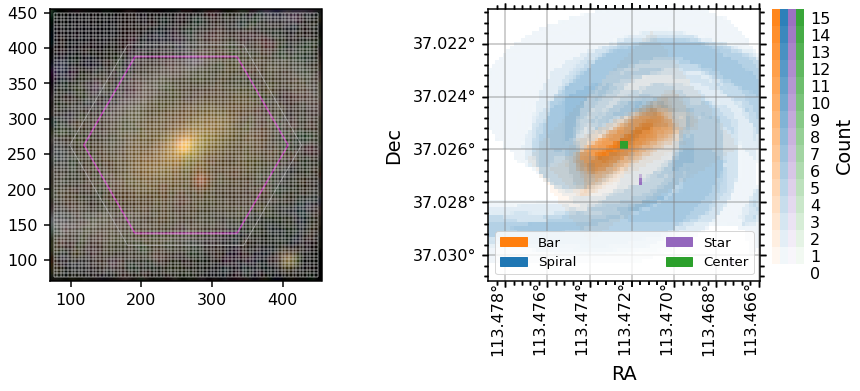

In [10]:
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, wspace=0.4)

ax0 = plt.subplot(gs[0])
ax0.imshow(data.image)
# add the correct IFU hexagon to the image plot
ax0.add_patch(data.get_hexagon(edgecolor='C7'))

# plot the lines for the spaxel grid
v_grid, h_grid = data.get_spaxel_grid()
ax0.vlines(v_grid[0], ymin=v_grid[1][0], ymax=v_grid[1][1], color='white', alpha=0.2)
ax0.hlines(h_grid[1], xmin=h_grid[0][0], xmax=h_grid[0][1], color='white', alpha=0.2)

# zoom in on the image to show the grid clearly
ax0.set_xlim(70, 455)
ax0.set_ylim(70, 455)

# plot the spaxel masks
data.plot_masks(color_grid='grey', spaxel_masks=True, subplot_spec=gs[1])
ax1 = fig.axes[1]

# flip the y-axis to match the orientation of other plots
ax1.set_ylim(*ax1.get_ylim()[::-1]);

## Placing contours on Marvin maps

To get an image in the same orientation as the maps you can use `marvin.tools.Image`, plot it along side the spaxel masks, and use the masks as contours on top of any Marvin map plot. For these plots we are only showing one contour level the corresponds to four or more volunteers marking a spaxel as belonging to each of the masks.

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


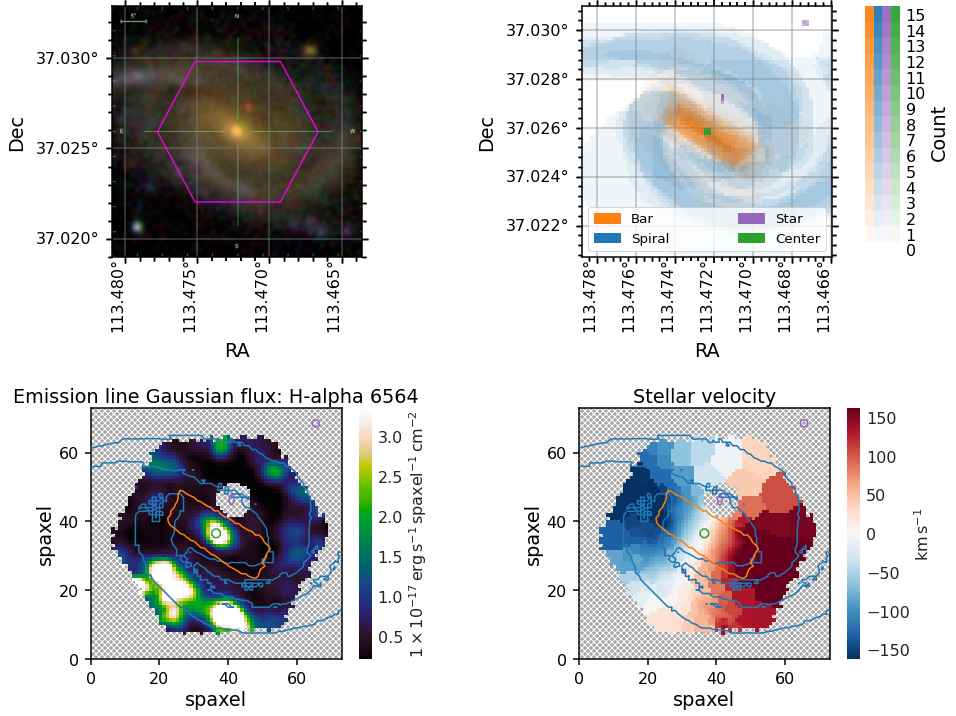

In [16]:
image = marvin.tools.Image(manga_id)

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.6)

# original image as stroed in Marvin
ax0 = plt.subplot(gs[0, 0], projection=image.wcs)
data._set_up_axes(ax0, color_grid='grey')
ax0.imshow(image.data)

# The masks plotted on the spaxel grid
ax1 = plt.subplot(gs[0, 1])
data.plot_masks(color_grid='grey', spaxel_masks=True, subplot_spec=gs[1])

# Using the masks as contours on the H-alpha map
ax2 = plt.subplot(gs[1, 0])
data.maps.emline_gflux_ha_6564.plot(ax=ax2, fig=fig)
ax2.contour(data.spiral_mask_spaxel, levels=[4], zorder=20, colors='C0')
ax2.contour(data.bar_mask_spaxel, levels=[4], zorder=20, colors='C1')
ax2.contour(data.center_mask_spaxel, levels=[4], zorder=20, colors='C2')
ax2.contour(data.star_mask_spaxel, levels=[4], zorder=20, colors='C4')

# Useing the masks as countours on the stellar velocity map
ax3 = plt.subplot(gs[1, 1])
data.maps.stellar_vel.plot(ax=ax3, fig=fig)
ax3.contour(data.spiral_mask_spaxel, levels=[4], zorder=20, colors='C0')
ax3.contour(data.bar_mask_spaxel, levels=[4], zorder=20, colors='C1')
ax3.contour(data.center_mask_spaxel, levels=[4], zorder=20, colors='C2')
ax3.contour(data.star_mask_spaxel, levels=[4], zorder=20, colors='C4');

## Plotting BPT diagrams

The GZ3D class has a special method for plotting BPT diagrams, `plot_bpt`, that are color coded by what mask each spaxel belongs to. There are three flavors that can be made by passing in `bpt_kind` as either `"log_nii_ha"`, `"log_sii_ha"`, or `"log_oi_ha"`.  Any other keywords are passed to matplotlib's `scatter` function (in this example we pass the keyword `s` that controls the scatter point size).

Note: When making a legend sometimes there is transparency on the legend symbols, see the code below for an easy way to remove the alpha effect.

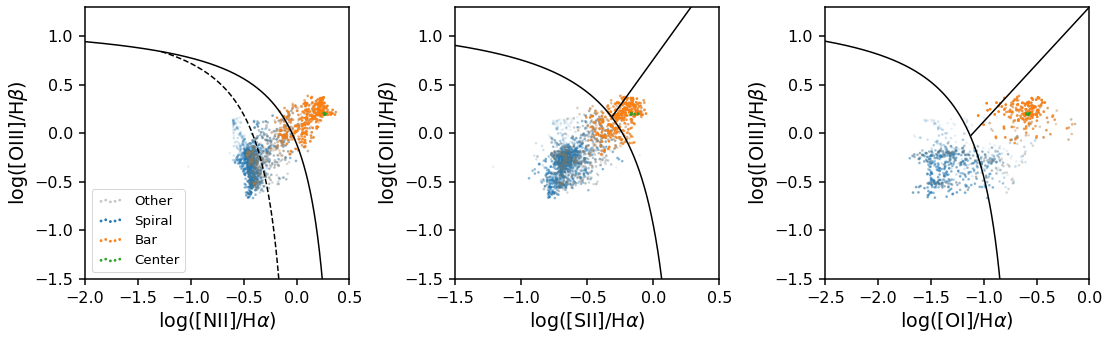

In [17]:
plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.4)

ax0 = plt.subplot(gs[0])
data.plot_bpt(ax=ax0, bpt_kind='log_nii_ha', s=3)
legend = ax0.legend(loc=3)

# remove transparency from legend
for lh in legend.legendHandles: 
    lh.set_alpha(1)

ax1 = plt.subplot(gs[1])
data.plot_bpt(ax=ax1, bpt_kind='log_sii_ha', s=3)

ax2 = plt.subplot(gs[2])
data.plot_bpt(ax=ax2, bpt_kind='log_oi_ha', s=3);

## Mean spectra

The `get_mean_spectra` method will calculate the weighted mean spectra inside each mask (weighted by classification counts).  After running this method new attributes will become available for `mean_spiral`, `mean_bar`, and `mean_center` that will return `marvin.tools.quantities.spectrum` objects with the mean spectra.  The `error` for these mean spectra is fully calculated and accounts for spacial covariance as outlined in Westfall et al. 2019.

By using the `inv=True` keyword it will also calculate the mean spectra of the inverted masks (e.g. mean of all *not* spiral spaxels, etc..).  This can be used for calculating difference spectrum to look for excess inside various masks over the background.

In [18]:
data.get_mean_spectra(inv=True)

[WARNING]: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here. (DeprecationWarning)
[WARNING]: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information. (DeprecationWarning)


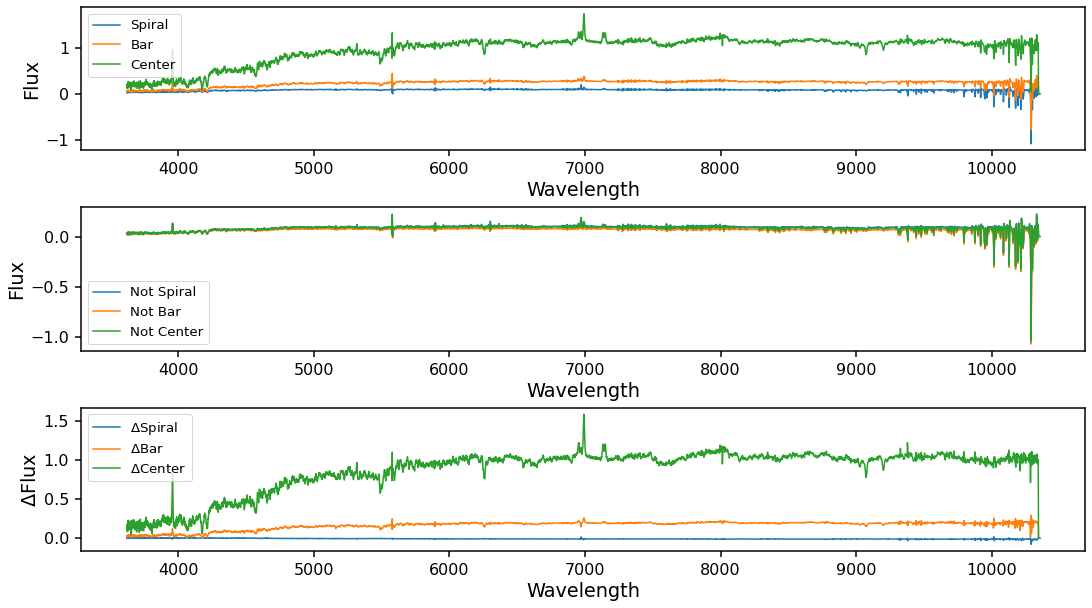

In [22]:
plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(3, 1, hspace=0.4)

# Mean spectra for Spiral, Bar, and Center masks
ax0 = plt.subplot(gs[0])

ax0.plot(data.mean_spiral.wavelength, data.mean_spiral, color='C0', label='Spiral')
ax0.plot(data.mean_bar.wavelength, data.mean_bar, color='C1', label='Bar')
ax0.plot(data.mean_center.wavelength, data.mean_center, color='C2', label='Center')

ax0.set_xlabel('Wavelength')
ax0.set_ylabel('Flux')
ax0.legend()

# Mean spectra for the inverse masks
ax1 = plt.subplot(gs[1])

ax1.plot(data.mean_not_spiral.wavelength, data.mean_not_spiral, color='C0', label='Not Spiral')
ax1.plot(data.mean_not_bar.wavelength, data.mean_not_bar, color='C1', label='Not Bar')
ax1.plot(data.mean_not_center.wavelength, data.mean_not_center, color='C2', label='Not Center')

ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Flux')
ax1.legend()

# Difference spectra for each mask
ax2 = plt.subplot(gs[2])

ax2.plot(data.mean_not_spiral.wavelength, data.mean_spiral - data.mean_not_spiral, color='C0', label='$\\Delta\\mathrm{{Spiral}}$')
ax2.plot(data.mean_not_bar.wavelength, data.mean_bar - data.mean_not_bar, color='C1', label='$\\Delta\\mathrm{{Bar}}$')
ax2.plot(data.mean_not_center.wavelength, data.mean_center - data.mean_not_center, color='C2', label='$\\Delta\\mathrm{{Center}}$')

ax2.set_xlabel('Wavelength')
ax2.set_ylabel('$\\Delta\\mathrm{{Flux}}$')
ax2.legend();

## Polar plots

The final plot types supported by the GZ3D class are polar plots.  These can either be by `theta` or `R/R_50` by changing the `x_unit` keyword from `theta` to `radius`.  Any MaNGA map can be passed in under the `key` keyword and you will need to provide the correct `ylabel` (units will automatically be added to the `ylabel` based on the map chosen).

The default map is `D_n 4000`.

[WARNING]: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead (DeprecationWarning)


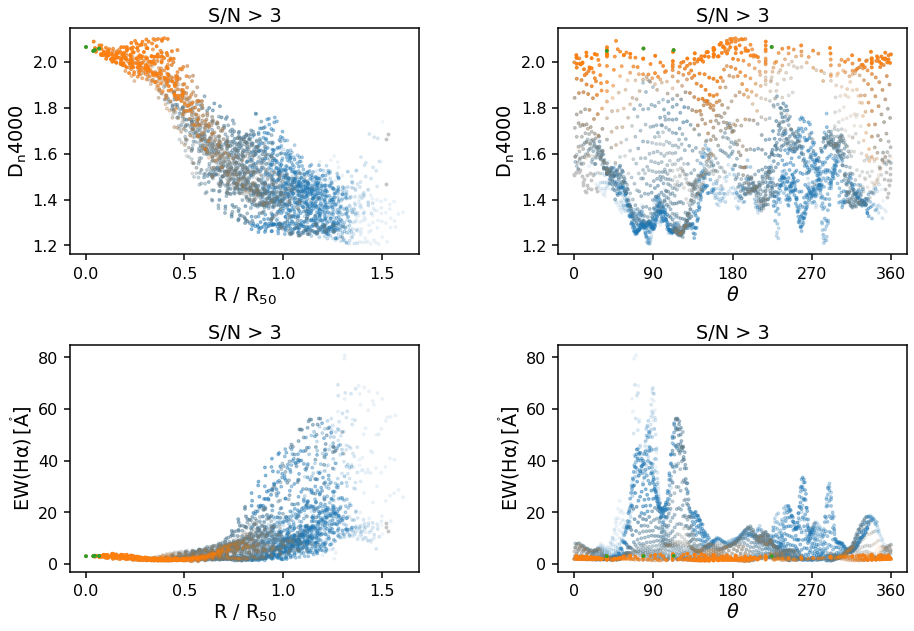

In [23]:
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, hspace=0.4, wspace=0.4)

# D_n 4000 vs radius
ax0 = plt.subplot(gs[0, 0])
data.polar_plot(x_unit='radius', ax=ax0)

# D_n 4000 vs theta
ax1 = plt.subplot(gs[0, 1])
data.polar_plot(x_unit='theta', ax=ax1)

# EW(H-alpha) vs radius
ax2 = plt.subplot(gs[1, 0])
data.polar_plot(x_unit='radius', key='emline_sew_ha_6564', ylabel='EW(H\\alpha)', ax=ax2)

# EW(H-alpha) vs theta
ax3 = plt.subplot(gs[1, 1])
data.polar_plot(x_unit='theta', key='emline_sew_ha_6564', ylabel='EW(H\\alpha)', ax=ax3);

Note that the zero theta line is different for each galaxy.  You can check what direction it points by plotting the theta map along side the spaxel masks:

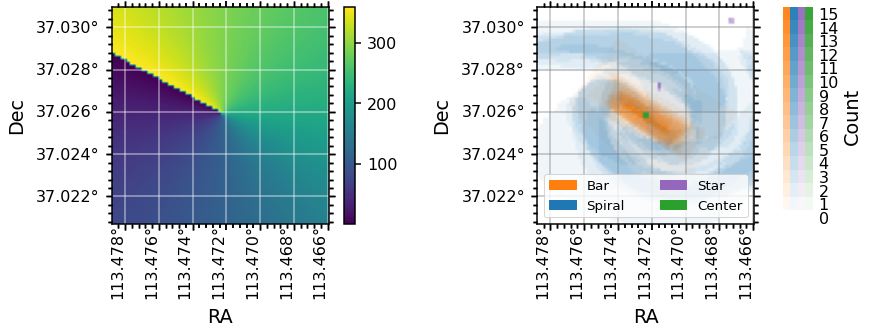

In [24]:
fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, wspace=0.4)

# theta map
ax0 = plt.subplot(gs[0], projection=data.maps.wcs)
im = ax0.imshow(data.maps.spx_ellcoo_elliptical_azimuth.value)
# change the default units and labels on the axes
data._set_up_axes(ax0, color_grid='white')
# incluce a colorbar for the theta map
fig.colorbar(im, ax=ax0)

# plot the spaxel masks
data.plot_masks(color_grid='grey', spaxel_masks=True, subplot_spec=gs[1])
ax1 = fig.axes[1]